# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

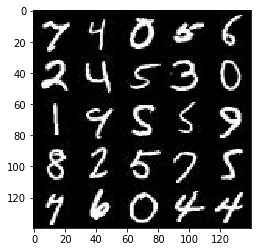

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

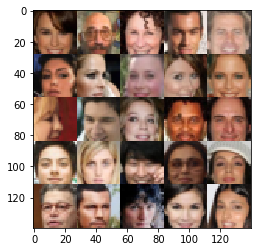

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    input_images = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name='input_real')
    
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return (input_images, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1

    with tf.variable_scope("discriminator", reuse=reuse):

        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        relu1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same")
        normalization2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha*normalization2, normalization2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding="same")
        normalization3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha*normalization3, normalization3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1

    with tf.variable_scope("generator", reuse= not is_train):

        fullyConLayer = tf.layers.dense(z, 7*7*256)
        
        fullyConLayer = tf.reshape(fullyConLayer, (-1, 7, 7, 256))
        normalization1 = tf.layers.batch_normalization(fullyConLayer, training=is_train)
        relu1 = tf.maximum(alpha*normalization1, normalization1)
        
        conv2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding="same")
        normalization2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.maximum(alpha*normalization2, normalization2)
        
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding="same")
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Smoothing 
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs( data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images*2.0
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess,25, input_z, data_shape[3], data_image_mode)

    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.0377... Generator Loss: 5.6691
Epoch 0/2... Discriminator Loss: 0.0333... Generator Loss: 8.9295
Epoch 0/2... Discriminator Loss: 2.1019... Generator Loss: 3.7831
Epoch 0/2... Discriminator Loss: 4.5743... Generator Loss: 0.0502
Epoch 0/2... Discriminator Loss: 0.8439... Generator Loss: 1.3794
Epoch 0/2... Discriminator Loss: 1.5354... Generator Loss: 0.4390
Epoch 0/2... Discriminator Loss: 1.3391... Generator Loss: 1.5497
Epoch 0/2... Discriminator Loss: 2.0136... Generator Loss: 1.5779
Epoch 0/2... Discriminator Loss: 2.1334... Generator Loss: 2.4297
Epoch 0/2... Discriminator Loss: 2.2573... Generator Loss: 0.2468


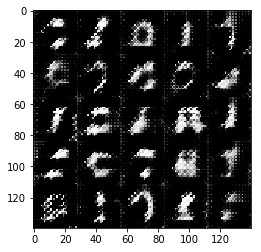

Epoch 0/2... Discriminator Loss: 2.1592... Generator Loss: 0.1659
Epoch 0/2... Discriminator Loss: 1.5580... Generator Loss: 0.8498
Epoch 0/2... Discriminator Loss: 1.4660... Generator Loss: 0.5711
Epoch 0/2... Discriminator Loss: 1.6230... Generator Loss: 0.3421
Epoch 0/2... Discriminator Loss: 1.2380... Generator Loss: 0.7219
Epoch 0/2... Discriminator Loss: 1.9886... Generator Loss: 0.3459
Epoch 0/2... Discriminator Loss: 1.5299... Generator Loss: 0.4900
Epoch 0/2... Discriminator Loss: 1.1196... Generator Loss: 0.5898
Epoch 0/2... Discriminator Loss: 1.5976... Generator Loss: 0.4975
Epoch 0/2... Discriminator Loss: 1.1173... Generator Loss: 1.3775


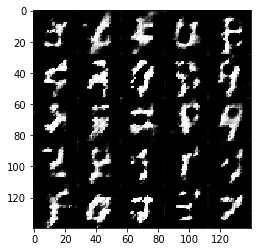

Epoch 0/2... Discriminator Loss: 1.2579... Generator Loss: 0.4659
Epoch 0/2... Discriminator Loss: 1.5068... Generator Loss: 1.0176
Epoch 0/2... Discriminator Loss: 1.2836... Generator Loss: 0.6064
Epoch 0/2... Discriminator Loss: 2.0329... Generator Loss: 0.2263
Epoch 0/2... Discriminator Loss: 1.8882... Generator Loss: 0.3450
Epoch 0/2... Discriminator Loss: 1.4648... Generator Loss: 0.5378
Epoch 0/2... Discriminator Loss: 1.9472... Generator Loss: 2.2829
Epoch 0/2... Discriminator Loss: 1.2899... Generator Loss: 0.9505
Epoch 0/2... Discriminator Loss: 1.7748... Generator Loss: 0.2615
Epoch 0/2... Discriminator Loss: 2.3244... Generator Loss: 2.6771


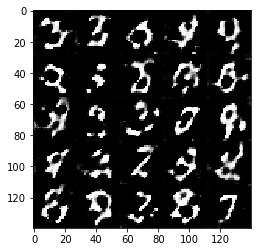

Epoch 0/2... Discriminator Loss: 1.2373... Generator Loss: 1.0571
Epoch 0/2... Discriminator Loss: 1.5353... Generator Loss: 0.4073
Epoch 0/2... Discriminator Loss: 1.4213... Generator Loss: 0.9525
Epoch 0/2... Discriminator Loss: 1.5106... Generator Loss: 0.4017
Epoch 0/2... Discriminator Loss: 1.7502... Generator Loss: 1.2684
Epoch 0/2... Discriminator Loss: 1.4046... Generator Loss: 1.4785
Epoch 0/2... Discriminator Loss: 1.2618... Generator Loss: 0.7482
Epoch 0/2... Discriminator Loss: 1.1073... Generator Loss: 0.8916
Epoch 0/2... Discriminator Loss: 1.3758... Generator Loss: 0.6626
Epoch 0/2... Discriminator Loss: 1.5107... Generator Loss: 1.0217


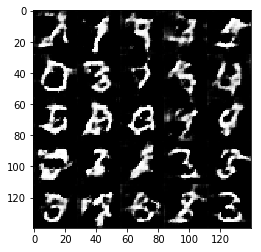

Epoch 0/2... Discriminator Loss: 1.1350... Generator Loss: 1.6385
Epoch 0/2... Discriminator Loss: 1.1348... Generator Loss: 1.4501
Epoch 0/2... Discriminator Loss: 1.7884... Generator Loss: 0.2976
Epoch 0/2... Discriminator Loss: 1.4129... Generator Loss: 0.5938
Epoch 0/2... Discriminator Loss: 1.4472... Generator Loss: 0.4750
Epoch 0/2... Discriminator Loss: 1.4748... Generator Loss: 0.4579
Epoch 0/2... Discriminator Loss: 1.2701... Generator Loss: 0.5599
Epoch 0/2... Discriminator Loss: 1.6098... Generator Loss: 0.3617
Epoch 0/2... Discriminator Loss: 1.3579... Generator Loss: 1.0084
Epoch 0/2... Discriminator Loss: 1.4687... Generator Loss: 0.4475


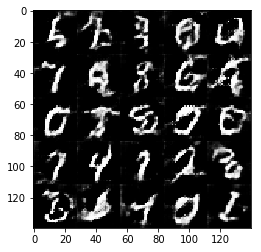

Epoch 0/2... Discriminator Loss: 1.1687... Generator Loss: 0.6844
Epoch 0/2... Discriminator Loss: 1.4082... Generator Loss: 0.8943
Epoch 0/2... Discriminator Loss: 1.2508... Generator Loss: 1.8389
Epoch 0/2... Discriminator Loss: 1.3743... Generator Loss: 0.6513
Epoch 0/2... Discriminator Loss: 1.2885... Generator Loss: 0.5945
Epoch 0/2... Discriminator Loss: 1.2659... Generator Loss: 1.2157
Epoch 0/2... Discriminator Loss: 1.7634... Generator Loss: 0.2689
Epoch 0/2... Discriminator Loss: 1.4063... Generator Loss: 0.8557
Epoch 0/2... Discriminator Loss: 1.3652... Generator Loss: 0.5412
Epoch 0/2... Discriminator Loss: 1.3216... Generator Loss: 0.7385


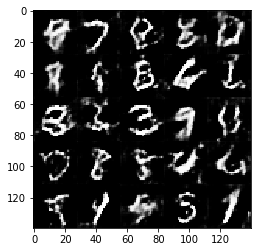

Epoch 0/2... Discriminator Loss: 1.6472... Generator Loss: 1.3904
Epoch 0/2... Discriminator Loss: 1.5028... Generator Loss: 0.7202
Epoch 0/2... Discriminator Loss: 1.4493... Generator Loss: 0.5688
Epoch 0/2... Discriminator Loss: 1.3481... Generator Loss: 0.6436
Epoch 0/2... Discriminator Loss: 1.0293... Generator Loss: 0.9030
Epoch 0/2... Discriminator Loss: 0.9695... Generator Loss: 1.0093
Epoch 0/2... Discriminator Loss: 1.2289... Generator Loss: 0.7329
Epoch 0/2... Discriminator Loss: 1.1397... Generator Loss: 0.7917
Epoch 0/2... Discriminator Loss: 1.2280... Generator Loss: 0.5597
Epoch 0/2... Discriminator Loss: 1.2174... Generator Loss: 0.5515


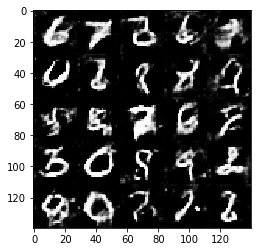

Epoch 0/2... Discriminator Loss: 1.5578... Generator Loss: 0.3317
Epoch 0/2... Discriminator Loss: 1.1613... Generator Loss: 1.0827
Epoch 0/2... Discriminator Loss: 1.1260... Generator Loss: 0.8731
Epoch 0/2... Discriminator Loss: 1.1623... Generator Loss: 0.6467
Epoch 0/2... Discriminator Loss: 1.2902... Generator Loss: 0.6379
Epoch 0/2... Discriminator Loss: 1.0239... Generator Loss: 0.9309
Epoch 0/2... Discriminator Loss: 1.1367... Generator Loss: 0.7080
Epoch 0/2... Discriminator Loss: 1.5493... Generator Loss: 0.3324
Epoch 0/2... Discriminator Loss: 1.2841... Generator Loss: 1.7213
Epoch 0/2... Discriminator Loss: 1.2055... Generator Loss: 0.6498


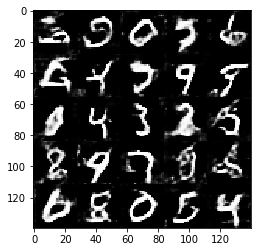

Epoch 0/2... Discriminator Loss: 1.3241... Generator Loss: 1.4832
Epoch 0/2... Discriminator Loss: 1.4905... Generator Loss: 0.3974
Epoch 0/2... Discriminator Loss: 1.4051... Generator Loss: 0.5732
Epoch 0/2... Discriminator Loss: 1.1580... Generator Loss: 0.7202
Epoch 0/2... Discriminator Loss: 1.3180... Generator Loss: 0.5839
Epoch 0/2... Discriminator Loss: 1.1629... Generator Loss: 0.6402
Epoch 0/2... Discriminator Loss: 1.1571... Generator Loss: 1.1710
Epoch 0/2... Discriminator Loss: 1.1565... Generator Loss: 0.6447
Epoch 0/2... Discriminator Loss: 1.3612... Generator Loss: 0.4476
Epoch 0/2... Discriminator Loss: 1.1032... Generator Loss: 1.1683


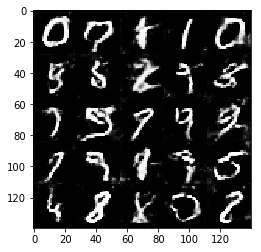

Epoch 0/2... Discriminator Loss: 1.1046... Generator Loss: 0.7827
Epoch 0/2... Discriminator Loss: 1.1458... Generator Loss: 1.3590
Epoch 0/2... Discriminator Loss: 1.6832... Generator Loss: 0.2993
Epoch 1/2... Discriminator Loss: 1.3177... Generator Loss: 0.5951
Epoch 1/2... Discriminator Loss: 1.1433... Generator Loss: 1.0670
Epoch 1/2... Discriminator Loss: 1.2413... Generator Loss: 0.6422
Epoch 1/2... Discriminator Loss: 1.0852... Generator Loss: 0.7251
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 1.0959
Epoch 1/2... Discriminator Loss: 1.1761... Generator Loss: 0.7194
Epoch 1/2... Discriminator Loss: 1.9819... Generator Loss: 0.2364


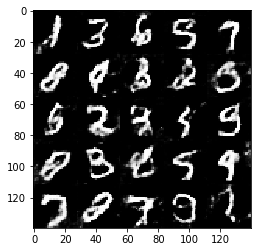

Epoch 1/2... Discriminator Loss: 1.1810... Generator Loss: 0.5578
Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 0.7293
Epoch 1/2... Discriminator Loss: 1.1027... Generator Loss: 0.7414
Epoch 1/2... Discriminator Loss: 1.4834... Generator Loss: 0.4568
Epoch 1/2... Discriminator Loss: 1.0489... Generator Loss: 0.8011
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 0.9064
Epoch 1/2... Discriminator Loss: 1.0029... Generator Loss: 0.9173
Epoch 1/2... Discriminator Loss: 1.1023... Generator Loss: 0.7450
Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 1.2869
Epoch 1/2... Discriminator Loss: 0.9298... Generator Loss: 1.1928


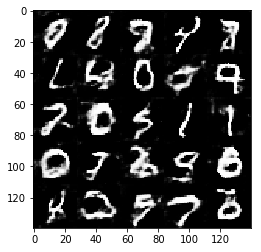

Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 1.2048
Epoch 1/2... Discriminator Loss: 1.5918... Generator Loss: 0.3567
Epoch 1/2... Discriminator Loss: 1.3403... Generator Loss: 0.5206
Epoch 1/2... Discriminator Loss: 0.9917... Generator Loss: 1.6712
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 0.7706
Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 2.0644
Epoch 1/2... Discriminator Loss: 0.8540... Generator Loss: 1.5251
Epoch 1/2... Discriminator Loss: 1.4813... Generator Loss: 0.4286
Epoch 1/2... Discriminator Loss: 1.1548... Generator Loss: 0.6267
Epoch 1/2... Discriminator Loss: 1.4729... Generator Loss: 0.4357


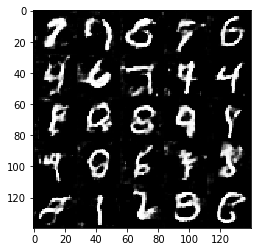

Epoch 1/2... Discriminator Loss: 0.9591... Generator Loss: 1.2925
Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 0.5786
Epoch 1/2... Discriminator Loss: 0.9524... Generator Loss: 1.1562
Epoch 1/2... Discriminator Loss: 1.9087... Generator Loss: 0.3417
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 1.0758
Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 2.0410
Epoch 1/2... Discriminator Loss: 1.5438... Generator Loss: 0.3887
Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 1.4564
Epoch 1/2... Discriminator Loss: 0.8920... Generator Loss: 1.7314
Epoch 1/2... Discriminator Loss: 1.1028... Generator Loss: 1.7362


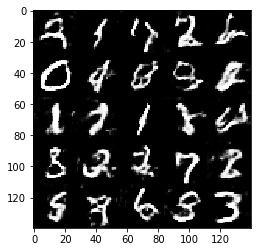

Epoch 1/2... Discriminator Loss: 1.0521... Generator Loss: 0.8128
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 2.0976
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.5573
Epoch 1/2... Discriminator Loss: 0.7003... Generator Loss: 2.4739
Epoch 1/2... Discriminator Loss: 2.2523... Generator Loss: 0.1727
Epoch 1/2... Discriminator Loss: 1.1166... Generator Loss: 1.4747
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 0.6472
Epoch 1/2... Discriminator Loss: 0.8189... Generator Loss: 1.3398
Epoch 1/2... Discriminator Loss: 0.7096... Generator Loss: 1.3096
Epoch 1/2... Discriminator Loss: 0.9897... Generator Loss: 0.7603


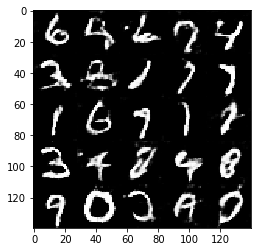

Epoch 1/2... Discriminator Loss: 1.3252... Generator Loss: 0.7075
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.6468
Epoch 1/2... Discriminator Loss: 0.9964... Generator Loss: 1.0956
Epoch 1/2... Discriminator Loss: 1.4259... Generator Loss: 0.5211
Epoch 1/2... Discriminator Loss: 1.1974... Generator Loss: 0.9882
Epoch 1/2... Discriminator Loss: 0.8098... Generator Loss: 1.2604
Epoch 1/2... Discriminator Loss: 1.0751... Generator Loss: 0.8084
Epoch 1/2... Discriminator Loss: 1.4530... Generator Loss: 0.4563
Epoch 1/2... Discriminator Loss: 1.6243... Generator Loss: 0.4109
Epoch 1/2... Discriminator Loss: 1.0568... Generator Loss: 1.3718


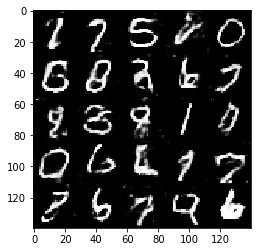

Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 1.0861
Epoch 1/2... Discriminator Loss: 1.9332... Generator Loss: 2.3892
Epoch 1/2... Discriminator Loss: 1.5466... Generator Loss: 0.9928
Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 0.7212
Epoch 1/2... Discriminator Loss: 1.4927... Generator Loss: 0.3672
Epoch 1/2... Discriminator Loss: 0.9496... Generator Loss: 0.8861
Epoch 1/2... Discriminator Loss: 1.4154... Generator Loss: 0.4531
Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 0.6626
Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 0.8764
Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 2.1491


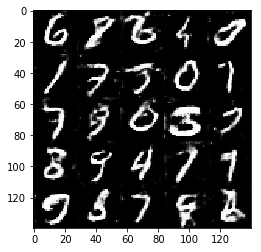

Epoch 1/2... Discriminator Loss: 0.9923... Generator Loss: 1.1428
Epoch 1/2... Discriminator Loss: 1.1356... Generator Loss: 0.7783
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 0.7220
Epoch 1/2... Discriminator Loss: 1.2848... Generator Loss: 0.5691
Epoch 1/2... Discriminator Loss: 1.2904... Generator Loss: 0.5566
Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 0.5278
Epoch 1/2... Discriminator Loss: 2.1503... Generator Loss: 0.2261
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 2.9223
Epoch 1/2... Discriminator Loss: 1.5047... Generator Loss: 0.4566
Epoch 1/2... Discriminator Loss: 0.9466... Generator Loss: 1.9191


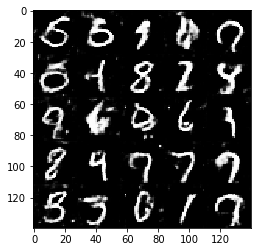

Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 1.4644... Generator Loss: 0.4343
Epoch 1/2... Discriminator Loss: 1.2659... Generator Loss: 1.3869
Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 0.7570
Epoch 1/2... Discriminator Loss: 0.8689... Generator Loss: 0.9533
Epoch 1/2... Discriminator Loss: 0.8236... Generator Loss: 1.5420
Epoch 1/2... Discriminator Loss: 0.6120... Generator Loss: 1.4683
Epoch 1/2... Discriminator Loss: 1.0810... Generator Loss: 0.7143
Epoch 1/2... Discriminator Loss: 1.7833... Generator Loss: 0.3197
Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.6495


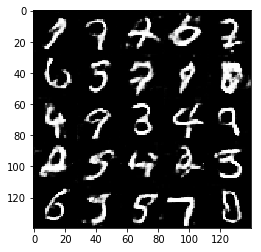

Epoch 1/2... Discriminator Loss: 1.6723... Generator Loss: 0.4081
Epoch 1/2... Discriminator Loss: 2.0101... Generator Loss: 0.2143
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 0.7946
Epoch 1/2... Discriminator Loss: 2.4254... Generator Loss: 0.1555
Epoch 1/2... Discriminator Loss: 0.6707... Generator Loss: 1.2145
Epoch 1/2... Discriminator Loss: 1.5829... Generator Loss: 2.2482
Epoch 1/2... Discriminator Loss: 1.0168... Generator Loss: 0.8985


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.2317... Generator Loss: 2.1113
Epoch 0/1... Discriminator Loss: 0.1413... Generator Loss: 2.6895
Epoch 0/1... Discriminator Loss: 0.1767... Generator Loss: 2.4233
Epoch 0/1... Discriminator Loss: 0.0730... Generator Loss: 3.6827
Epoch 0/1... Discriminator Loss: 0.0687... Generator Loss: 3.6121
Epoch 0/1... Discriminator Loss: 0.0711... Generator Loss: 3.9370
Epoch 0/1... Discriminator Loss: 0.0514... Generator Loss: 3.5841
Epoch 0/1... Discriminator Loss: 0.1609... Generator Loss: 5.1001
Epoch 0/1... Discriminator Loss: 0.1333... Generator Loss: 3.7059
Epoch 0/1... Discriminator Loss: 0.6106... Generator Loss: 1.6190


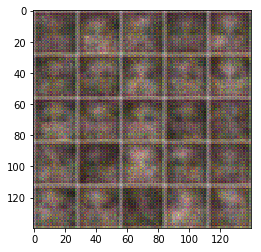

Epoch 0/1... Discriminator Loss: 0.4541... Generator Loss: 3.1350
Epoch 0/1... Discriminator Loss: 0.6522... Generator Loss: 2.5574
Epoch 0/1... Discriminator Loss: 0.5395... Generator Loss: 1.9464
Epoch 0/1... Discriminator Loss: 0.3511... Generator Loss: 1.8997
Epoch 0/1... Discriminator Loss: 0.6253... Generator Loss: 1.1186
Epoch 0/1... Discriminator Loss: 0.4699... Generator Loss: 2.1606
Epoch 0/1... Discriminator Loss: 0.4377... Generator Loss: 2.0787
Epoch 0/1... Discriminator Loss: 0.5627... Generator Loss: 2.1186
Epoch 0/1... Discriminator Loss: 0.6881... Generator Loss: 1.0535
Epoch 0/1... Discriminator Loss: 0.4488... Generator Loss: 2.2515


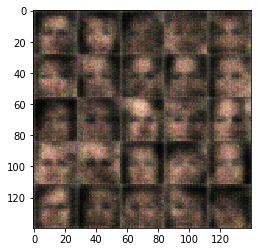

Epoch 0/1... Discriminator Loss: 0.6016... Generator Loss: 2.1930
Epoch 0/1... Discriminator Loss: 0.6892... Generator Loss: 1.5460
Epoch 0/1... Discriminator Loss: 0.7355... Generator Loss: 1.0267
Epoch 0/1... Discriminator Loss: 0.6341... Generator Loss: 1.1968
Epoch 0/1... Discriminator Loss: 0.5021... Generator Loss: 2.0311
Epoch 0/1... Discriminator Loss: 0.7480... Generator Loss: 1.0286
Epoch 0/1... Discriminator Loss: 0.4318... Generator Loss: 2.2976
Epoch 0/1... Discriminator Loss: 0.6625... Generator Loss: 1.9970
Epoch 0/1... Discriminator Loss: 1.3783... Generator Loss: 1.9002
Epoch 0/1... Discriminator Loss: 0.4819... Generator Loss: 1.6799


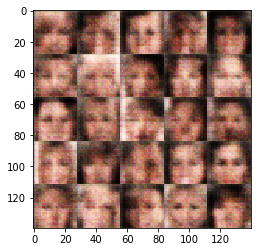

Epoch 0/1... Discriminator Loss: 0.3438... Generator Loss: 2.0347
Epoch 0/1... Discriminator Loss: 1.1885... Generator Loss: 0.8083
Epoch 0/1... Discriminator Loss: 0.6523... Generator Loss: 1.3081
Epoch 0/1... Discriminator Loss: 0.5853... Generator Loss: 1.5100
Epoch 0/1... Discriminator Loss: 0.9849... Generator Loss: 0.9284
Epoch 0/1... Discriminator Loss: 0.5694... Generator Loss: 1.5088
Epoch 0/1... Discriminator Loss: 0.4256... Generator Loss: 1.8290
Epoch 0/1... Discriminator Loss: 1.1608... Generator Loss: 0.7700
Epoch 0/1... Discriminator Loss: 1.0109... Generator Loss: 1.8623
Epoch 0/1... Discriminator Loss: 0.8418... Generator Loss: 1.2627


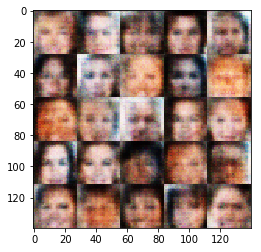

Epoch 0/1... Discriminator Loss: 0.7299... Generator Loss: 1.5195
Epoch 0/1... Discriminator Loss: 0.8078... Generator Loss: 1.2912
Epoch 0/1... Discriminator Loss: 0.8854... Generator Loss: 0.9261
Epoch 0/1... Discriminator Loss: 0.7064... Generator Loss: 1.5545
Epoch 0/1... Discriminator Loss: 0.7675... Generator Loss: 1.0487
Epoch 0/1... Discriminator Loss: 0.7094... Generator Loss: 1.1745
Epoch 0/1... Discriminator Loss: 0.9922... Generator Loss: 0.6515
Epoch 0/1... Discriminator Loss: 0.6856... Generator Loss: 1.2110
Epoch 0/1... Discriminator Loss: 0.7475... Generator Loss: 1.1993
Epoch 0/1... Discriminator Loss: 0.7972... Generator Loss: 1.5322


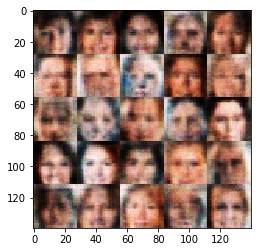

Epoch 0/1... Discriminator Loss: 0.7734... Generator Loss: 1.7108
Epoch 0/1... Discriminator Loss: 0.6595... Generator Loss: 1.4002
Epoch 0/1... Discriminator Loss: 0.7291... Generator Loss: 0.9934
Epoch 0/1... Discriminator Loss: 0.6064... Generator Loss: 1.4554
Epoch 0/1... Discriminator Loss: 0.9905... Generator Loss: 0.6419
Epoch 0/1... Discriminator Loss: 0.6029... Generator Loss: 1.5063
Epoch 0/1... Discriminator Loss: 0.6998... Generator Loss: 1.2844
Epoch 0/1... Discriminator Loss: 0.7009... Generator Loss: 2.0580
Epoch 0/1... Discriminator Loss: 0.6217... Generator Loss: 1.6538
Epoch 0/1... Discriminator Loss: 0.6110... Generator Loss: 1.2099


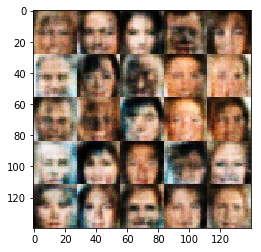

Epoch 0/1... Discriminator Loss: 0.6888... Generator Loss: 1.6489
Epoch 0/1... Discriminator Loss: 0.8082... Generator Loss: 1.0120
Epoch 0/1... Discriminator Loss: 0.7204... Generator Loss: 1.8148
Epoch 0/1... Discriminator Loss: 0.7016... Generator Loss: 1.7011
Epoch 0/1... Discriminator Loss: 0.5869... Generator Loss: 1.4877
Epoch 0/1... Discriminator Loss: 0.6543... Generator Loss: 1.3019
Epoch 0/1... Discriminator Loss: 0.7360... Generator Loss: 1.1353
Epoch 0/1... Discriminator Loss: 0.6245... Generator Loss: 1.7766
Epoch 0/1... Discriminator Loss: 0.7214... Generator Loss: 1.1181
Epoch 0/1... Discriminator Loss: 0.5897... Generator Loss: 1.3689


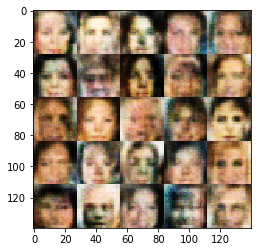

Epoch 0/1... Discriminator Loss: 0.8566... Generator Loss: 0.8166
Epoch 0/1... Discriminator Loss: 0.6301... Generator Loss: 1.2387
Epoch 0/1... Discriminator Loss: 0.5908... Generator Loss: 1.6389
Epoch 0/1... Discriminator Loss: 0.6659... Generator Loss: 1.7914
Epoch 0/1... Discriminator Loss: 1.1753... Generator Loss: 0.5602
Epoch 0/1... Discriminator Loss: 0.6480... Generator Loss: 1.6645
Epoch 0/1... Discriminator Loss: 0.7559... Generator Loss: 0.8978
Epoch 0/1... Discriminator Loss: 0.8314... Generator Loss: 1.0395
Epoch 0/1... Discriminator Loss: 0.4918... Generator Loss: 2.6624
Epoch 0/1... Discriminator Loss: 0.8969... Generator Loss: 1.7665


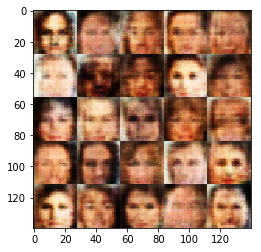

Epoch 0/1... Discriminator Loss: 1.0075... Generator Loss: 1.2082
Epoch 0/1... Discriminator Loss: 1.0670... Generator Loss: 1.3644
Epoch 0/1... Discriminator Loss: 0.6199... Generator Loss: 1.2221
Epoch 0/1... Discriminator Loss: 0.6638... Generator Loss: 1.3168
Epoch 0/1... Discriminator Loss: 0.8378... Generator Loss: 1.1826
Epoch 0/1... Discriminator Loss: 0.7543... Generator Loss: 1.1410
Epoch 0/1... Discriminator Loss: 0.7956... Generator Loss: 1.3244
Epoch 0/1... Discriminator Loss: 0.9853... Generator Loss: 0.9039
Epoch 0/1... Discriminator Loss: 0.9233... Generator Loss: 1.4813
Epoch 0/1... Discriminator Loss: 0.9121... Generator Loss: 1.0774


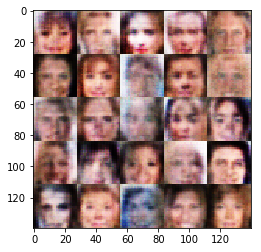

Epoch 0/1... Discriminator Loss: 1.2386... Generator Loss: 0.6231
Epoch 0/1... Discriminator Loss: 0.9924... Generator Loss: 1.1639
Epoch 0/1... Discriminator Loss: 0.8246... Generator Loss: 1.4899
Epoch 0/1... Discriminator Loss: 0.9390... Generator Loss: 0.7681
Epoch 0/1... Discriminator Loss: 1.1968... Generator Loss: 0.7560
Epoch 0/1... Discriminator Loss: 0.8517... Generator Loss: 1.0785
Epoch 0/1... Discriminator Loss: 0.7988... Generator Loss: 0.9349
Epoch 0/1... Discriminator Loss: 0.9645... Generator Loss: 0.9734
Epoch 0/1... Discriminator Loss: 0.8556... Generator Loss: 0.9146
Epoch 0/1... Discriminator Loss: 1.0479... Generator Loss: 0.7960


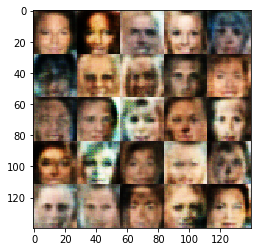

Epoch 0/1... Discriminator Loss: 0.9160... Generator Loss: 1.0005
Epoch 0/1... Discriminator Loss: 0.9754... Generator Loss: 1.0540
Epoch 0/1... Discriminator Loss: 0.7881... Generator Loss: 1.0837
Epoch 0/1... Discriminator Loss: 0.8626... Generator Loss: 1.0821
Epoch 0/1... Discriminator Loss: 0.9176... Generator Loss: 1.2483
Epoch 0/1... Discriminator Loss: 0.9385... Generator Loss: 1.2340
Epoch 0/1... Discriminator Loss: 0.8753... Generator Loss: 1.1153
Epoch 0/1... Discriminator Loss: 1.0531... Generator Loss: 0.6973
Epoch 0/1... Discriminator Loss: 0.8929... Generator Loss: 1.0110
Epoch 0/1... Discriminator Loss: 0.8432... Generator Loss: 1.1766


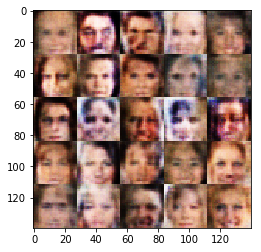

Epoch 0/1... Discriminator Loss: 1.0262... Generator Loss: 0.7635
Epoch 0/1... Discriminator Loss: 0.9573... Generator Loss: 1.1238
Epoch 0/1... Discriminator Loss: 0.9217... Generator Loss: 1.1140
Epoch 0/1... Discriminator Loss: 0.9917... Generator Loss: 0.9164
Epoch 0/1... Discriminator Loss: 0.9859... Generator Loss: 1.0441
Epoch 0/1... Discriminator Loss: 1.0716... Generator Loss: 0.8167
Epoch 0/1... Discriminator Loss: 0.9376... Generator Loss: 1.1171
Epoch 0/1... Discriminator Loss: 0.9471... Generator Loss: 1.1077
Epoch 0/1... Discriminator Loss: 1.0330... Generator Loss: 0.8706
Epoch 0/1... Discriminator Loss: 1.0568... Generator Loss: 0.9455


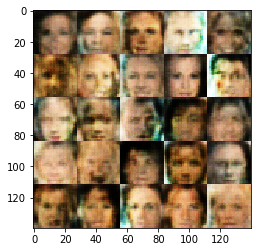

Epoch 0/1... Discriminator Loss: 1.0041... Generator Loss: 0.9983
Epoch 0/1... Discriminator Loss: 0.9264... Generator Loss: 0.9287
Epoch 0/1... Discriminator Loss: 0.9536... Generator Loss: 0.8498
Epoch 0/1... Discriminator Loss: 0.9191... Generator Loss: 1.2354
Epoch 0/1... Discriminator Loss: 1.0272... Generator Loss: 0.7579
Epoch 0/1... Discriminator Loss: 0.8559... Generator Loss: 1.0718
Epoch 0/1... Discriminator Loss: 0.8459... Generator Loss: 1.2128
Epoch 0/1... Discriminator Loss: 0.9310... Generator Loss: 1.0712
Epoch 0/1... Discriminator Loss: 1.0244... Generator Loss: 0.9326
Epoch 0/1... Discriminator Loss: 0.8398... Generator Loss: 0.9338


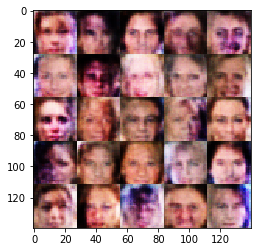

Epoch 0/1... Discriminator Loss: 0.8304... Generator Loss: 1.1731
Epoch 0/1... Discriminator Loss: 0.9399... Generator Loss: 1.0971
Epoch 0/1... Discriminator Loss: 0.9388... Generator Loss: 0.9217
Epoch 0/1... Discriminator Loss: 1.0096... Generator Loss: 0.7039
Epoch 0/1... Discriminator Loss: 0.8997... Generator Loss: 0.9399
Epoch 0/1... Discriminator Loss: 1.0030... Generator Loss: 0.7062
Epoch 0/1... Discriminator Loss: 0.9120... Generator Loss: 1.1637
Epoch 0/1... Discriminator Loss: 0.9355... Generator Loss: 0.9852
Epoch 0/1... Discriminator Loss: 1.0583... Generator Loss: 0.8019
Epoch 0/1... Discriminator Loss: 0.9088... Generator Loss: 0.8478


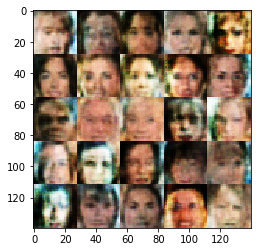

Epoch 0/1... Discriminator Loss: 0.8224... Generator Loss: 1.0702
Epoch 0/1... Discriminator Loss: 1.0725... Generator Loss: 1.0050
Epoch 0/1... Discriminator Loss: 0.8997... Generator Loss: 0.9606
Epoch 0/1... Discriminator Loss: 0.8380... Generator Loss: 1.1786
Epoch 0/1... Discriminator Loss: 0.8565... Generator Loss: 1.0021
Epoch 0/1... Discriminator Loss: 0.9119... Generator Loss: 1.1997
Epoch 0/1... Discriminator Loss: 0.8738... Generator Loss: 1.3221
Epoch 0/1... Discriminator Loss: 1.0300... Generator Loss: 1.1414
Epoch 0/1... Discriminator Loss: 0.9029... Generator Loss: 1.0051
Epoch 0/1... Discriminator Loss: 0.9913... Generator Loss: 0.8799


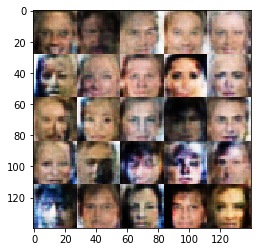

Epoch 0/1... Discriminator Loss: 0.9617... Generator Loss: 1.0598
Epoch 0/1... Discriminator Loss: 1.0715... Generator Loss: 1.1332
Epoch 0/1... Discriminator Loss: 0.7902... Generator Loss: 1.2829
Epoch 0/1... Discriminator Loss: 0.7932... Generator Loss: 1.1180
Epoch 0/1... Discriminator Loss: 0.8784... Generator Loss: 0.9793
Epoch 0/1... Discriminator Loss: 0.8984... Generator Loss: 1.2122
Epoch 0/1... Discriminator Loss: 0.9501... Generator Loss: 1.1827
Epoch 0/1... Discriminator Loss: 0.8306... Generator Loss: 1.1060
Epoch 0/1... Discriminator Loss: 1.0112... Generator Loss: 0.7342
Epoch 0/1... Discriminator Loss: 0.8933... Generator Loss: 1.4085


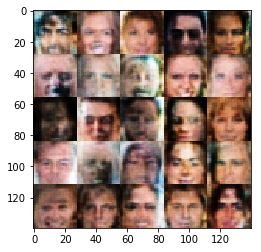

Epoch 0/1... Discriminator Loss: 0.8454... Generator Loss: 1.1241
Epoch 0/1... Discriminator Loss: 0.9374... Generator Loss: 0.8915
Epoch 0/1... Discriminator Loss: 0.8895... Generator Loss: 0.9374
Epoch 0/1... Discriminator Loss: 0.8533... Generator Loss: 1.3122
Epoch 0/1... Discriminator Loss: 1.0121... Generator Loss: 0.9455
Epoch 0/1... Discriminator Loss: 1.0007... Generator Loss: 0.8821
Epoch 0/1... Discriminator Loss: 0.8868... Generator Loss: 0.9908
Epoch 0/1... Discriminator Loss: 0.8010... Generator Loss: 1.0543
Epoch 0/1... Discriminator Loss: 0.8934... Generator Loss: 1.1080
Epoch 0/1... Discriminator Loss: 0.9595... Generator Loss: 0.8869


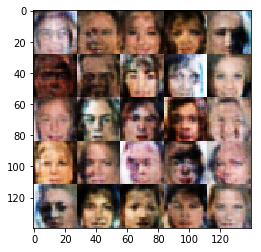

Epoch 0/1... Discriminator Loss: 0.8302... Generator Loss: 1.0789
Epoch 0/1... Discriminator Loss: 0.8343... Generator Loss: 1.0741
Epoch 0/1... Discriminator Loss: 0.9423... Generator Loss: 0.9099
Epoch 0/1... Discriminator Loss: 0.9148... Generator Loss: 0.8577
Epoch 0/1... Discriminator Loss: 0.7756... Generator Loss: 1.5199
Epoch 0/1... Discriminator Loss: 1.1800... Generator Loss: 0.5317
Epoch 0/1... Discriminator Loss: 0.9652... Generator Loss: 1.0916
Epoch 0/1... Discriminator Loss: 0.8645... Generator Loss: 1.2177
Epoch 0/1... Discriminator Loss: 1.0030... Generator Loss: 1.1709
Epoch 0/1... Discriminator Loss: 0.7846... Generator Loss: 1.2973


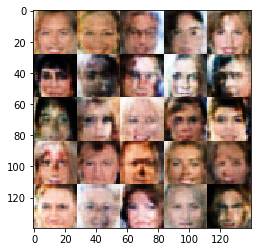

Epoch 0/1... Discriminator Loss: 0.8158... Generator Loss: 0.9958
Epoch 0/1... Discriminator Loss: 0.9240... Generator Loss: 1.0716
Epoch 0/1... Discriminator Loss: 0.8681... Generator Loss: 0.9445
Epoch 0/1... Discriminator Loss: 0.8322... Generator Loss: 1.2277
Epoch 0/1... Discriminator Loss: 0.8698... Generator Loss: 1.0523
Epoch 0/1... Discriminator Loss: 0.8537... Generator Loss: 0.9516
Epoch 0/1... Discriminator Loss: 0.8396... Generator Loss: 1.0752
Epoch 0/1... Discriminator Loss: 0.8862... Generator Loss: 0.8657
Epoch 0/1... Discriminator Loss: 0.7639... Generator Loss: 1.1177
Epoch 0/1... Discriminator Loss: 0.7940... Generator Loss: 1.0507


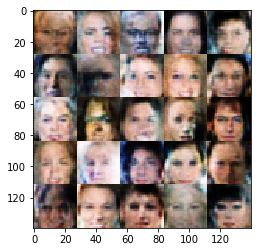

Epoch 0/1... Discriminator Loss: 1.0710... Generator Loss: 0.6537
Epoch 0/1... Discriminator Loss: 1.2357... Generator Loss: 0.6122
Epoch 0/1... Discriminator Loss: 1.0315... Generator Loss: 0.7681
Epoch 0/1... Discriminator Loss: 1.0163... Generator Loss: 1.0378
Epoch 0/1... Discriminator Loss: 0.8949... Generator Loss: 1.0365
Epoch 0/1... Discriminator Loss: 0.8637... Generator Loss: 0.9389
Epoch 0/1... Discriminator Loss: 0.7355... Generator Loss: 1.4404
Epoch 0/1... Discriminator Loss: 1.1015... Generator Loss: 0.7684
Epoch 0/1... Discriminator Loss: 1.0410... Generator Loss: 0.8959
Epoch 0/1... Discriminator Loss: 0.8447... Generator Loss: 1.1566


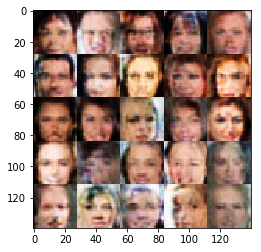

Epoch 0/1... Discriminator Loss: 0.7192... Generator Loss: 1.2096
Epoch 0/1... Discriminator Loss: 0.9261... Generator Loss: 1.1317
Epoch 0/1... Discriminator Loss: 0.9072... Generator Loss: 0.9764
Epoch 0/1... Discriminator Loss: 0.9659... Generator Loss: 0.9234
Epoch 0/1... Discriminator Loss: 0.9347... Generator Loss: 0.9205
Epoch 0/1... Discriminator Loss: 0.9174... Generator Loss: 0.9812
Epoch 0/1... Discriminator Loss: 0.8061... Generator Loss: 0.9813
Epoch 0/1... Discriminator Loss: 0.8356... Generator Loss: 1.2657
Epoch 0/1... Discriminator Loss: 0.8578... Generator Loss: 0.9283
Epoch 0/1... Discriminator Loss: 0.8218... Generator Loss: 1.0069


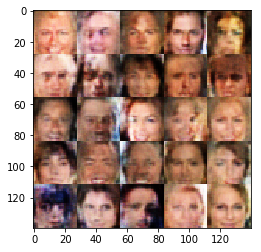

Epoch 0/1... Discriminator Loss: 0.8282... Generator Loss: 1.2264
Epoch 0/1... Discriminator Loss: 1.1216... Generator Loss: 0.5884
Epoch 0/1... Discriminator Loss: 1.0050... Generator Loss: 1.7942
Epoch 0/1... Discriminator Loss: 1.1187... Generator Loss: 1.1574
Epoch 0/1... Discriminator Loss: 0.9180... Generator Loss: 0.8815
Epoch 0/1... Discriminator Loss: 1.0066... Generator Loss: 0.7994
Epoch 0/1... Discriminator Loss: 0.8567... Generator Loss: 1.1648
Epoch 0/1... Discriminator Loss: 1.0611... Generator Loss: 0.7613
Epoch 0/1... Discriminator Loss: 0.8856... Generator Loss: 0.8500
Epoch 0/1... Discriminator Loss: 0.8643... Generator Loss: 1.3746


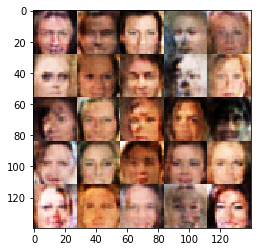

Epoch 0/1... Discriminator Loss: 0.8522... Generator Loss: 1.0377
Epoch 0/1... Discriminator Loss: 1.0833... Generator Loss: 0.6699
Epoch 0/1... Discriminator Loss: 0.9776... Generator Loss: 1.0553
Epoch 0/1... Discriminator Loss: 0.9333... Generator Loss: 1.0238
Epoch 0/1... Discriminator Loss: 0.6542... Generator Loss: 1.4722
Epoch 0/1... Discriminator Loss: 0.9254... Generator Loss: 0.8685
Epoch 0/1... Discriminator Loss: 0.9303... Generator Loss: 1.1171
Epoch 0/1... Discriminator Loss: 0.8856... Generator Loss: 0.9021
Epoch 0/1... Discriminator Loss: 0.9944... Generator Loss: 0.8353
Epoch 0/1... Discriminator Loss: 0.8878... Generator Loss: 1.2126


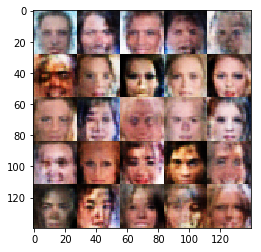

Epoch 0/1... Discriminator Loss: 0.9416... Generator Loss: 0.9357
Epoch 0/1... Discriminator Loss: 0.8848... Generator Loss: 0.9334
Epoch 0/1... Discriminator Loss: 0.8487... Generator Loss: 1.2724
Epoch 0/1... Discriminator Loss: 0.9420... Generator Loss: 1.1000
Epoch 0/1... Discriminator Loss: 1.0038... Generator Loss: 0.7125
Epoch 0/1... Discriminator Loss: 0.8580... Generator Loss: 0.9938
Epoch 0/1... Discriminator Loss: 0.7578... Generator Loss: 1.3690
Epoch 0/1... Discriminator Loss: 0.9675... Generator Loss: 0.8726
Epoch 0/1... Discriminator Loss: 0.9362... Generator Loss: 0.9615
Epoch 0/1... Discriminator Loss: 0.8108... Generator Loss: 1.1454


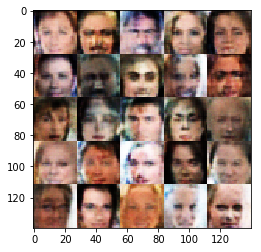

Epoch 0/1... Discriminator Loss: 0.8696... Generator Loss: 1.0630
Epoch 0/1... Discriminator Loss: 0.9326... Generator Loss: 0.9193
Epoch 0/1... Discriminator Loss: 1.0331... Generator Loss: 0.7636
Epoch 0/1... Discriminator Loss: 1.2863... Generator Loss: 0.4743
Epoch 0/1... Discriminator Loss: 0.8199... Generator Loss: 1.2215
Epoch 0/1... Discriminator Loss: 1.0798... Generator Loss: 0.6899
Epoch 0/1... Discriminator Loss: 0.6972... Generator Loss: 1.2777
Epoch 0/1... Discriminator Loss: 0.9460... Generator Loss: 0.9115
Epoch 0/1... Discriminator Loss: 0.9031... Generator Loss: 0.8529
Epoch 0/1... Discriminator Loss: 0.7840... Generator Loss: 1.2399


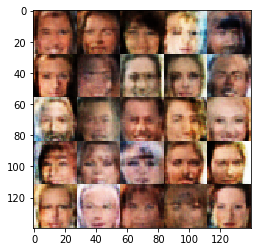

Epoch 0/1... Discriminator Loss: 0.8743... Generator Loss: 1.4018
Epoch 0/1... Discriminator Loss: 0.9514... Generator Loss: 0.8142
Epoch 0/1... Discriminator Loss: 1.0824... Generator Loss: 0.7253
Epoch 0/1... Discriminator Loss: 0.8202... Generator Loss: 1.4873
Epoch 0/1... Discriminator Loss: 0.9941... Generator Loss: 0.8464
Epoch 0/1... Discriminator Loss: 0.9666... Generator Loss: 1.9055
Epoch 0/1... Discriminator Loss: 0.9867... Generator Loss: 0.9581
Epoch 0/1... Discriminator Loss: 0.7541... Generator Loss: 1.1816
Epoch 0/1... Discriminator Loss: 0.9169... Generator Loss: 1.4103
Epoch 0/1... Discriminator Loss: 0.9854... Generator Loss: 0.8760


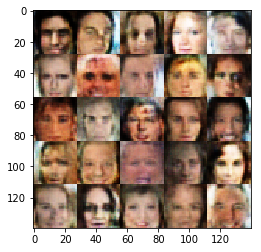

Epoch 0/1... Discriminator Loss: 0.9385... Generator Loss: 1.0980
Epoch 0/1... Discriminator Loss: 1.0274... Generator Loss: 0.7925
Epoch 0/1... Discriminator Loss: 0.8728... Generator Loss: 1.0179
Epoch 0/1... Discriminator Loss: 0.8299... Generator Loss: 1.2415
Epoch 0/1... Discriminator Loss: 0.9207... Generator Loss: 1.1963
Epoch 0/1... Discriminator Loss: 0.8446... Generator Loss: 1.4226
Epoch 0/1... Discriminator Loss: 1.0235... Generator Loss: 1.4295
Epoch 0/1... Discriminator Loss: 0.8997... Generator Loss: 1.0190
Epoch 0/1... Discriminator Loss: 0.9624... Generator Loss: 0.7325
Epoch 0/1... Discriminator Loss: 0.9237... Generator Loss: 1.0425


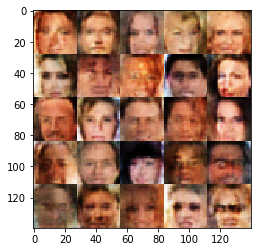

Epoch 0/1... Discriminator Loss: 0.9056... Generator Loss: 0.8980
Epoch 0/1... Discriminator Loss: 0.8001... Generator Loss: 1.2993
Epoch 0/1... Discriminator Loss: 0.9803... Generator Loss: 0.8837
Epoch 0/1... Discriminator Loss: 0.9468... Generator Loss: 1.0802
Epoch 0/1... Discriminator Loss: 0.8007... Generator Loss: 1.5447
Epoch 0/1... Discriminator Loss: 0.8852... Generator Loss: 1.0408
Epoch 0/1... Discriminator Loss: 0.8016... Generator Loss: 1.1820
Epoch 0/1... Discriminator Loss: 0.8848... Generator Loss: 0.9944
Epoch 0/1... Discriminator Loss: 0.8439... Generator Loss: 1.1713
Epoch 0/1... Discriminator Loss: 1.1067... Generator Loss: 0.7243


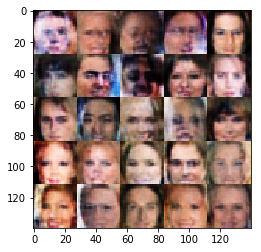

Epoch 0/1... Discriminator Loss: 0.8688... Generator Loss: 1.0910
Epoch 0/1... Discriminator Loss: 1.0463... Generator Loss: 0.7537
Epoch 0/1... Discriminator Loss: 1.0001... Generator Loss: 0.7075
Epoch 0/1... Discriminator Loss: 0.8990... Generator Loss: 0.9721
Epoch 0/1... Discriminator Loss: 0.9547... Generator Loss: 1.0827
Epoch 0/1... Discriminator Loss: 0.8404... Generator Loss: 1.2374
Epoch 0/1... Discriminator Loss: 0.9265... Generator Loss: 1.1583
Epoch 0/1... Discriminator Loss: 0.8959... Generator Loss: 0.9982
Epoch 0/1... Discriminator Loss: 0.9212... Generator Loss: 1.1446
Epoch 0/1... Discriminator Loss: 0.9619... Generator Loss: 0.9977


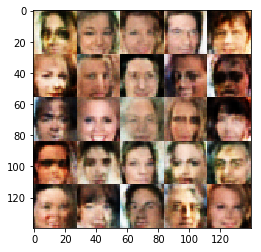

Epoch 0/1... Discriminator Loss: 0.8874... Generator Loss: 0.9751
Epoch 0/1... Discriminator Loss: 0.7695... Generator Loss: 1.0467
Epoch 0/1... Discriminator Loss: 0.8421... Generator Loss: 0.8883
Epoch 0/1... Discriminator Loss: 0.8493... Generator Loss: 0.9867
Epoch 0/1... Discriminator Loss: 0.9121... Generator Loss: 0.9003
Epoch 0/1... Discriminator Loss: 0.8174... Generator Loss: 1.0440
Epoch 0/1... Discriminator Loss: 0.8004... Generator Loss: 1.3908
Epoch 0/1... Discriminator Loss: 0.7739... Generator Loss: 1.0722
Epoch 0/1... Discriminator Loss: 0.9754... Generator Loss: 0.8059
Epoch 0/1... Discriminator Loss: 1.1445... Generator Loss: 0.6849


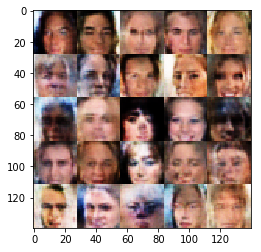

Epoch 0/1... Discriminator Loss: 1.0666... Generator Loss: 0.7439
Epoch 0/1... Discriminator Loss: 0.9229... Generator Loss: 0.9558
Epoch 0/1... Discriminator Loss: 0.8176... Generator Loss: 1.2859
Epoch 0/1... Discriminator Loss: 0.9909... Generator Loss: 0.7836
Epoch 0/1... Discriminator Loss: 0.8217... Generator Loss: 1.0392
Epoch 0/1... Discriminator Loss: 0.8246... Generator Loss: 1.3370
Epoch 0/1... Discriminator Loss: 0.8130... Generator Loss: 1.1192
Epoch 0/1... Discriminator Loss: 0.8039... Generator Loss: 1.0230
Epoch 0/1... Discriminator Loss: 0.7317... Generator Loss: 1.2722
Epoch 0/1... Discriminator Loss: 1.2015... Generator Loss: 0.5007


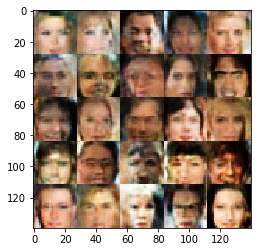

Epoch 0/1... Discriminator Loss: 0.8439... Generator Loss: 1.3373
Epoch 0/1... Discriminator Loss: 1.0217... Generator Loss: 0.9013
Epoch 0/1... Discriminator Loss: 1.0670... Generator Loss: 0.8978
Epoch 0/1... Discriminator Loss: 0.9187... Generator Loss: 0.9096
Epoch 0/1... Discriminator Loss: 0.9952... Generator Loss: 0.8375
Epoch 0/1... Discriminator Loss: 0.9576... Generator Loss: 0.8962


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.